# <b>Autoencoder for image generation</b>

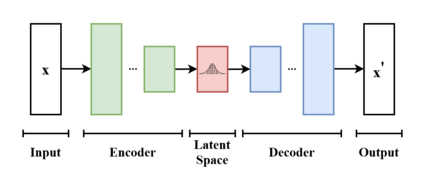
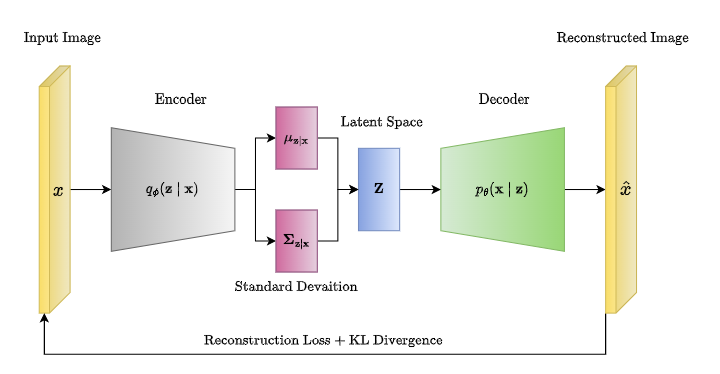
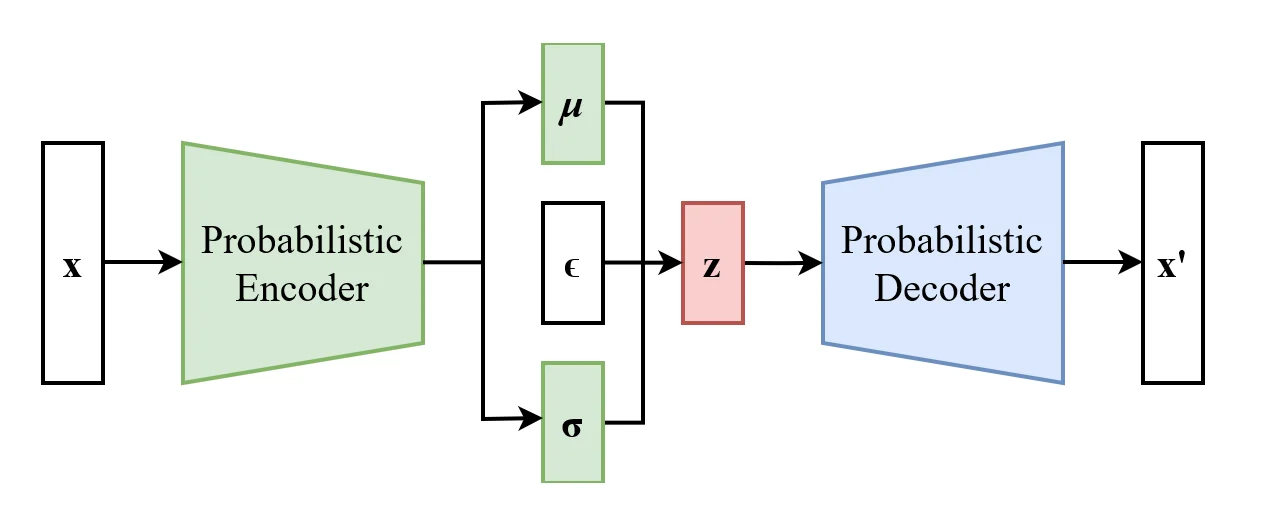
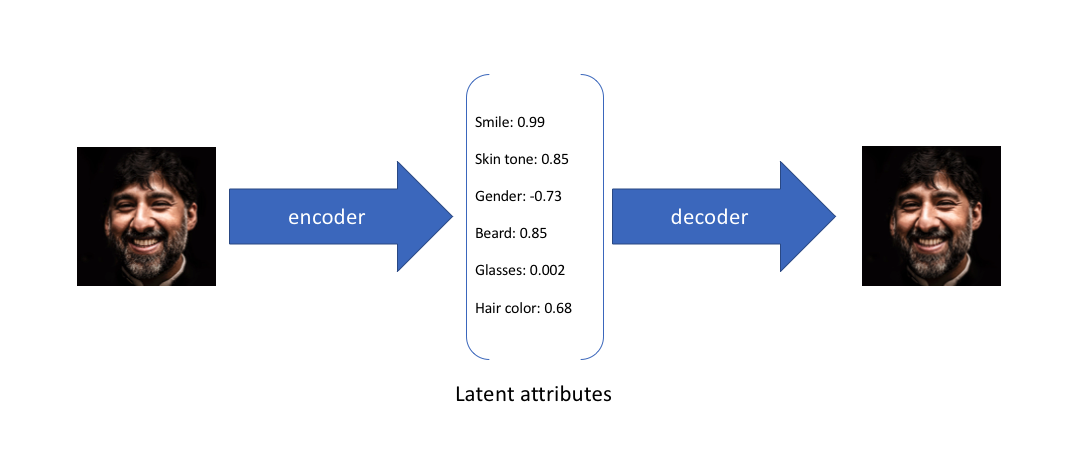

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [8]:
# Path to your image dataset
image_dir = "./dataset/training/balanced_flags/Test/"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),         # Convert to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1] for RGB channels
])

# Load the dataset
dataset = datasets.ImageFolder(root=image_dir, transform=transform)

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=64, 
                kernel_size=3, stride=2, padding=1  # (3, 128, 128) -> (64, 64, 64)
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64, out_channels=128, 
                kernel_size=3, stride=2, padding=1  # (64, 64, 64) -> (128, 32, 32)
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128, out_channels=256, 
                kernel_size=3, stride=2, padding=1  # (128, 32, 32) -> (256, 16, 16)
            ),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(
                in_features=256 * 16 * 16, out_features=1024  # Compress to latent vector
            ),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(
                in_features=1024, out_features=256 * 16 * 16
            ),
            nn.ReLU(),
            nn.Unflatten(
                dim=1, unflattened_size=(256, 16, 16)
            ),
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, 
                kernel_size=3, stride=2, padding=1, output_padding=1  # (256, 16, 16) -> (128, 32, 32)
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=128, out_channels=64, 
                kernel_size=3, stride=2, padding=1, output_padding=1  # (128, 32, 32) -> (64, 64, 64)
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=64, out_channels=3, 
                kernel_size=3, stride=2, padding=1, output_padding=1  # (64, 64, 64) -> (3, 128, 128)
            ),
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the autoencoder, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in dataloader:  
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)  
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Log epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

# Save the trained model
torch.save(model.state_dict(), "autoencoder_rgb.pth")

Epoch [1/20], Loss: 0.4296
Epoch [2/20], Loss: 0.3172
Epoch [3/20], Loss: 0.2165
Epoch [4/20], Loss: 0.2027
Epoch [5/20], Loss: 0.2223
Epoch [6/20], Loss: 0.2072
Epoch [7/20], Loss: 0.1789
Epoch [8/20], Loss: 0.1717
Epoch [9/20], Loss: 0.1692
Epoch [10/20], Loss: 0.1599
Epoch [11/20], Loss: 0.1785
Epoch [12/20], Loss: 0.1777
Epoch [13/20], Loss: 0.1582
Epoch [14/20], Loss: 0.1866
Epoch [15/20], Loss: 0.1676
Epoch [16/20], Loss: 0.1757
Epoch [17/20], Loss: 0.1498
Epoch [18/20], Loss: 0.1471
Epoch [19/20], Loss: 0.1532
Epoch [20/20], Loss: 0.1739


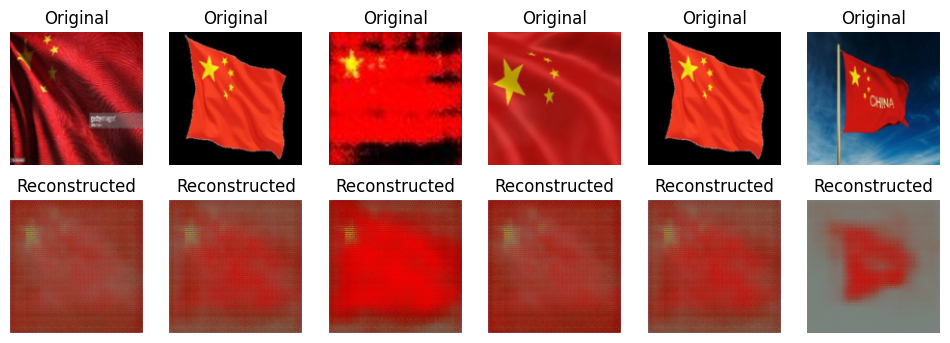

In [11]:
# Load the trained model
model.load_state_dict(torch.load("autoencoder_rgb.pth"))
model.eval()

# Visualize reconstruction
import matplotlib.pyplot as plt

# Get a batch of images
test_images, _ = next(iter(dataloader))
test_images = test_images.to(device)

# Generate reconstructions
with torch.no_grad():
    reconstructed = model(test_images)

# Convert images back to [0, 1] for display
test_images = test_images.cpu() * 0.5 + 0.5
reconstructed = reconstructed.cpu() * 0.5 + 0.5

# Display original and reconstructed images
fig, axes = plt.subplots(2, 6, figsize=(12, 4))
for i in range(6):
    # Original
    axes[0, i].imshow(test_images[i].permute(1, 2, 0))
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")
    
    # Reconstructed
    axes[1, i].imshow(reconstructed[i].permute(1, 2, 0))
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")
plt.show()